# Relax Challenge

## Identify  which  factors  predict  future  user adoption 

In [1]:
# import libraries
import pandas as pd   #ok
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# library for modeling 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')   #ok
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
engagement.head() 

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
users.head(2)  

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [6]:
users.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


#### Get adopted user
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period ,  
**identify  which  factors  predict  future  user adoption** 

In [7]:
Timedelta = pd.Timedelta('7 days') # seven days time  
Timedelta 

Timedelta('7 days 00:00:00')

In [8]:
# count the number of users  
len(engagement['user_id'].unique())

8823

In [9]:
# count unique visited value  
engagement['visited'].unique()

array([1], dtype=int64)

In [10]:
# Add week and day features based on time_stamp
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['dates']  = engagement.time_stamp.dt.date
engagement['week'] = engagement.time_stamp.dt.week
engagement['day'] = engagement.time_stamp.dt.day
engagement.head()

C:\Users\mirei\AppData\Local\Temp/ipykernel_22272/3565467043.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  engagement['week'] = engagement.time_stamp.dt.week


,time_stamp,user_id,visited,dates,week,day
0,2014-04-22 03:53:30,1,1,2014-04-22,17,22
1,2013-11-15 03:45:04,2,1,2013-11-15,46,15
2,2013-11-29 03:45:04,2,1,2013-11-29,48,29
3,2013-12-09 03:45:04,2,1,2013-12-09,50,9
4,2013-12-25 03:45:04,2,1,2013-12-25,52,25


In [11]:
# find duplicate
engagement.duplicated().sum()

0

In [12]:
# Group by week and user id, then find the number of visite greater than or equal to 3
#engagement.groupby(['week', 'user_id'])['day'].nunique()>=3 (another way to comple the same result)
data = engagement.groupby(['week', 'user_id'])['visited'].sum()>=3
data= data.reset_index()
data.head()

,week,user_id,visited
0,1,2,False
1,1,10,True
2,1,42,True
3,1,43,False
4,1,46,False


In [13]:
# get the percentage of adopted user in engagement dataset
len(data[data['visited']==True]['user_id'].unique())/len(engagement['user_id'].unique()) *100

16.377649325626205

In [14]:
# get the list of adopted user
adopted = list(data[data['visited']==True]['user_id'].unique())
print(len(adopted))
print(adopted [10:15])

1445
[168, 197, 202, 203, 209]


In [15]:
# Add new feature called 'adopted' as a boolean based on if a user is an adopted user
users['adopted'] = users['object_id'].isin(adopted)
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [17]:
len(users['object_id'].unique())

12000

In [18]:
# percentage of adapted user 
users['adopted'].mean()*100

12.041666666666668

## Exploratory data analysis 

In [19]:
df = users.copy(deep=True)

In [20]:
#users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [21]:
#users.last_session_creation_time.dt.strftime('%Y-%m')

In [22]:
df['adopted'].value_counts(normalize = True)

False    0.879583
True     0.120417
Name: adopted, dtype: float64

<AxesSubplot:>

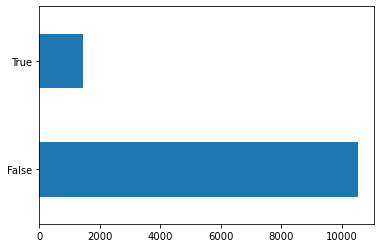

In [23]:
df['adopted'].value_counts().plot.barh()

C:\Users\mirei\AppData\Local\Temp/ipykernel_22272/2510397279.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  df.groupby(['creation_source'])['adopted'].mean().sort_values(0).plot(kind='barh')


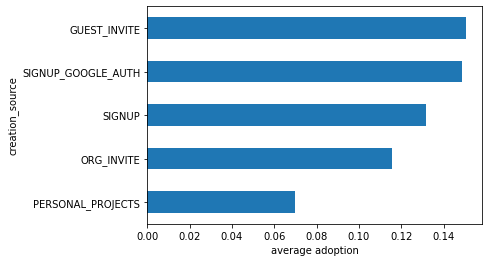

In [24]:
# Plot average adoption by creation source 
df.groupby(['creation_source'])['adopted'].mean().sort_values(0).plot(kind='barh')
plt.xlabel('average adoption')
plt.show()

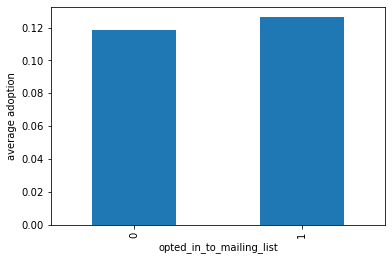

In [25]:
# Plot average adoption by whether or not the user opted in a mailing list
users.groupby(['opted_in_to_mailing_list'])['adopted'].mean().plot(kind='bar')
plt.ylabel('average adoption')
plt.show()

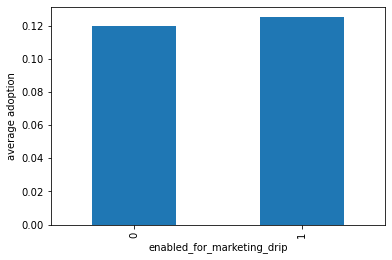

In [26]:
# Plot average adoption by whether or not the user enabled a marketing drip
users.groupby(['enabled_for_marketing_drip'])['adopted'].mean().plot(kind='bar')
plt.ylabel('average adoption')
plt.show()

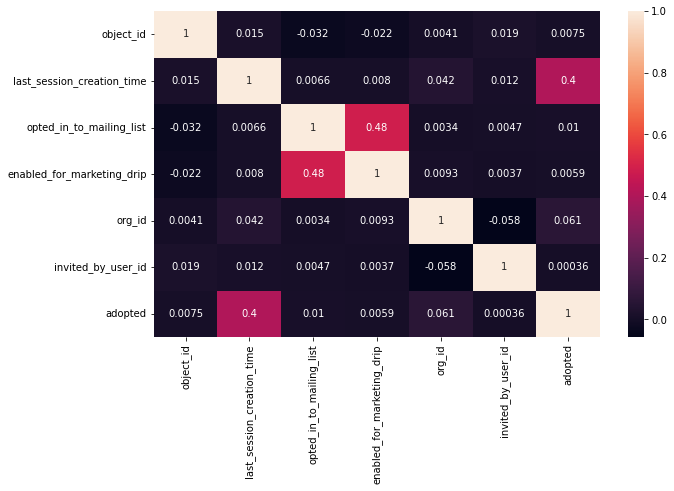

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(users.corr(),annot=True)
plt.show()

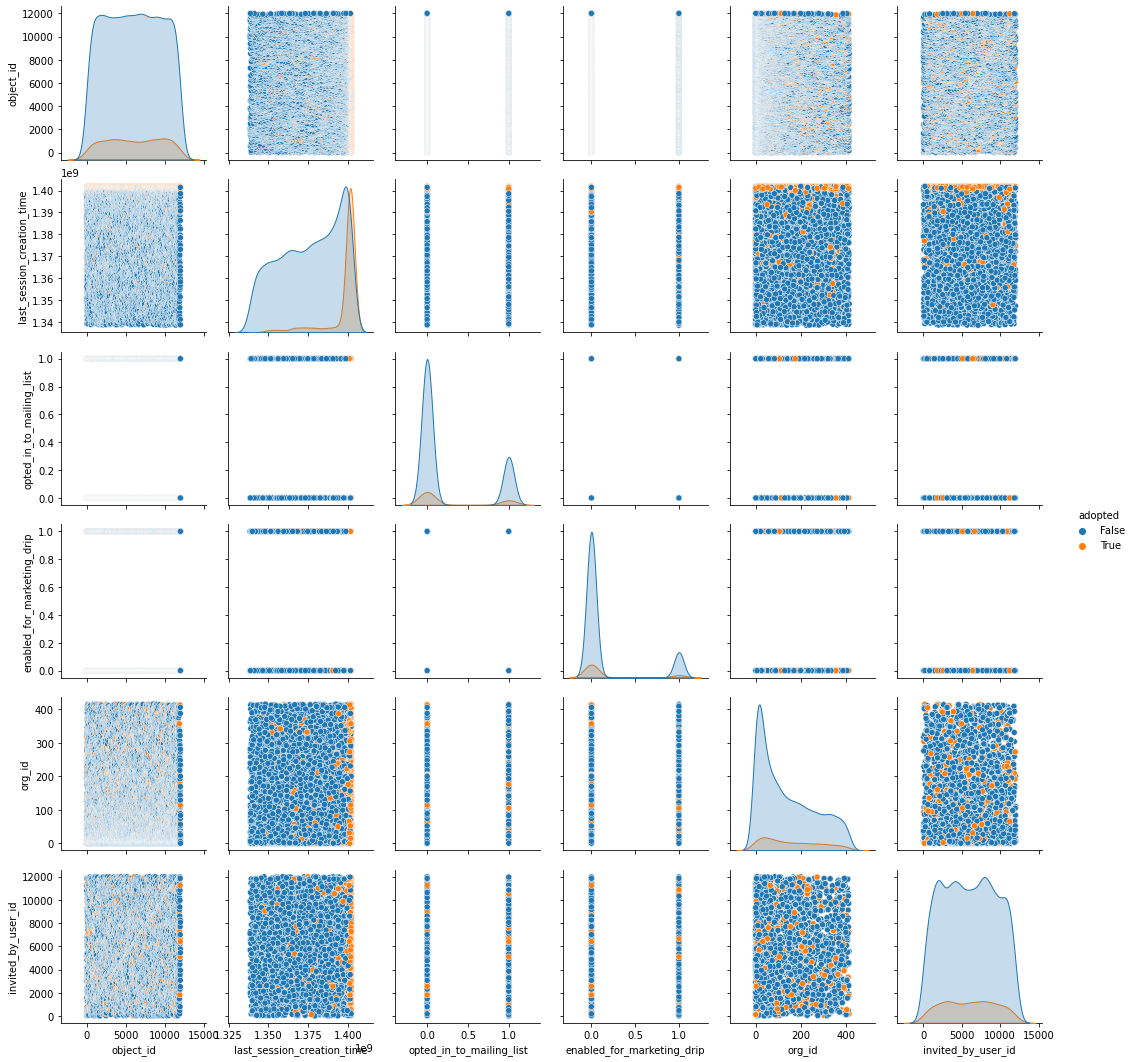

In [28]:
#plt.figure(figsize=(10,6))
sns.pairplot(data=users, hue='adopted')
plt.show()

### Pre_processing

In [29]:
users.duplicated().sum()

0

In [30]:
users.isnull().sum()/len(users)*100

object_id                      0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
adopted                        0.000
dtype: float64

In [31]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True


In [32]:
# features creations
#users['creation_time'] = pd.to_datetime(users['creation_time'])
#users['day_creation_time'] = users['creation_time'].apply(lambda x: x.day)
#users['week_creation_time'] = users['creation_time'].apply(lambda x: x.week)
#users['day_of_week_creation_time'] = users['creation_time'].apply(lambda x: x.dayofweek)

In [33]:
# REPLACE nULL VALUE # the mean (avg = users['last_session_creation_time'].mean()) or Bfill
users['last_session_creation_time'].fillna(method='bfill', inplace=True)

In [34]:
# fill NaN with 0
users.invited_by_user_id.fillna(0, inplace=True)

In [35]:
# change invited_by_user_id to binary value(1, 0)
users.invited_by_user_id = users.invited_by_user_id.apply(lambda x: 1 if x != 0 else x).astype('int64')

In [36]:
users.invited_by_user_id.value_counts()

1    6417
0    5583
Name: invited_by_user_id, dtype: int64

In [37]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

In [38]:
# drop unwanted column
users = users.drop(['object_id','creation_time','name', 'email', 'enabled_for_marketing_drip'], axis=1)

In [39]:
users = pd.get_dummies(users, prefix='is')

In [40]:
X=users.drop('adopted', axis=1)
y=users['adopted']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

### RANDOM FOREST

###  1st model 

In [42]:
rf_clf0= RandomForestClassifier()
rf_clf0.fit(X_train, y_train)
rf_clf0.score(X_test, y_test)

0.903

In [43]:
y_pred = rf_clf0.predict(X_test)
target_names = ['No_adopted', 'adopted']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  No_adopted       0.93      0.96      0.95      2639
     adopted       0.63      0.48      0.54       361

    accuracy                           0.90      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.89      0.90      0.90      3000



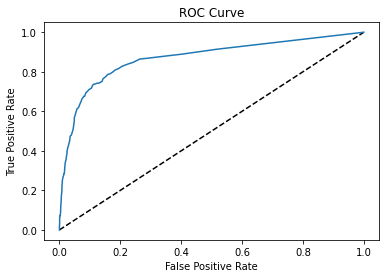

In [44]:
y_pred_prob = rf_clf0.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [45]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8686672005995724


In [46]:
# Compute cross-validated AUC scores: cv_auc
cv_rf = cross_val_score(rf_clf0, X_train, y_train, cv = 5, scoring = 'roc_auc')
print(cv_rf)
print(cv_rf.mean())

[0.8412379  0.84386526 0.86800859 0.81734646 0.84602968]
0.8432975783652168


### 2nd model

In [47]:
parameters = {"n_estimators": [40,60, 100],"max_features":['auto','sqrt'],"max_depth":[4, 8, 12, 20]}
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=0)

In [48]:
seed = 0
fitmodel = GridSearchCV(rf_clf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(X_train,y_train)
print('best estimator:',fitmodel.best_estimator_)
print('best params:',fitmodel.best_params_)
print('best score:',fitmodel.best_score_)

best estimator: RandomForestClassifier(max_depth=8, n_estimators=40, n_jobs=-1, random_state=0)
best params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 40}
best score: 0.901


In [49]:
rf_clf2 = RandomForestClassifier(n_estimators= 100, min_samples_split= 2, min_samples_leaf=3, max_features= 'auto', max_depth= 8)
rf_clf2 = rf_clf2.fit(X_train, y_train)
y_pred = rf_clf2.predict(X_test)

Text(0.5, 1.0, 'Random forest Feature importances ')

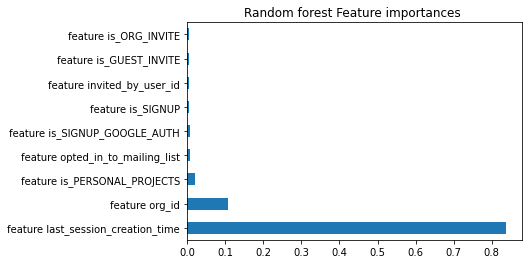

In [50]:
feat_importance = rf_clf2.feature_importances_
feature_names = [f"feature {i}" for i in X.columns]
forest_importances = pd.Series(feat_importance, index=feature_names).sort_values(ascending=False)
forest_importances.plot.barh()
plt.title("Random forest Feature importances ")

In [51]:
print (f'Train Accuracy - : { rf_clf2.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : { rf_clf2.score(X_test,y_test):.3f}')

Train Accuracy - : 0.922
Test Accuracy - : 0.915


In [52]:
target_names = ['No_adopted', 'adopted']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  No_adopted       0.93      0.97      0.95      2639
     adopted       0.71      0.50      0.58       361

    accuracy                           0.91      3000
   macro avg       0.82      0.73      0.77      3000
weighted avg       0.91      0.91      0.91      3000



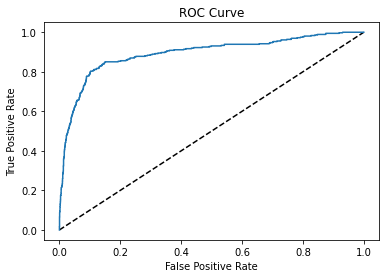

In [53]:
y_pred_prob = rf_clf2.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [54]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8922501703092017


In [55]:
# Compute cross-validated AUC scores: cv_auc
cv_rf2 = cross_val_score(rf_clf2, X_train, y_train, cv = 5, scoring = 'roc_auc')
print(cv_rf2)
print(cv_rf2.mean())

[0.86684408 0.88120031 0.89640798 0.83476657 0.87118025]
0.8700798378239615


### XGBOOST Model - 3rd model 

In [56]:
# XGBOOST Model - 1rst model 
XGB = XGBClassifier(n_estimators=1000,learning_rate=0.05)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
accuracy = accuracy_score(y_test,y_pred) #predictions
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[16:52:51] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 90.37%


In [57]:
target_names = ['No_adopted', 'adopted']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  No_adopted       0.93      0.96      0.95      2639
     adopted       0.63      0.48      0.55       361

    accuracy                           0.90      3000
   macro avg       0.78      0.72      0.75      3000
weighted avg       0.90      0.90      0.90      3000



[16:52:55] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

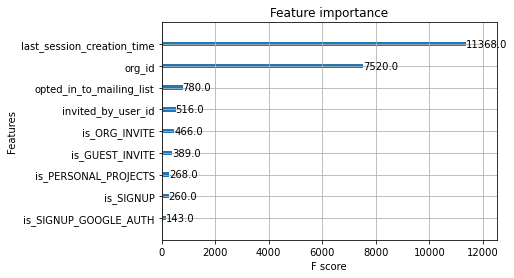

In [58]:
plot_importance(XGB.fit(X_train, y_train))

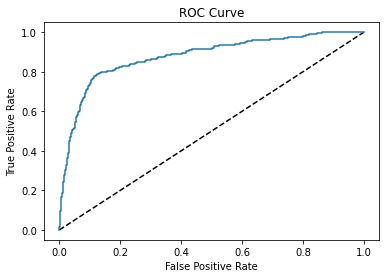

In [59]:
y_pred_prob = XGB.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [60]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8773700270500346


In [62]:
# Compute cross-validated AUC scores: cv_auc
#cv_xgb = cross_val_score(XGB, X_train, y_train, cv = 5, scoring = 'roc_auc')
#print(cv_xgb)
#print(cv_xgb.mean())